In [1]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [3]:
import torch
from torchvision import datasets, transforms
import helper

# Instructions from here:
# https://www.kaggle.com/ishvindersethi22/fashion-mnist-using-pytorch/data

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.], [0.5])])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

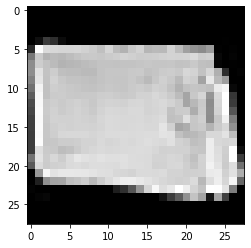

In [4]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.     # unnormalize
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    
images, label = next(iter(trainloader))
imshow(images[0, :])

In [6]:
from collections import OrderedDict
from torch import optim, nn

hidden_units = [4, 8, 16]
output_units = 10

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model_d = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, hidden_units[0], 3, stride=2, padding=1)),
            ('Relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(hidden_units[0], hidden_units[1], 3, stride=2, padding=1)),
            ('Relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(hidden_units[1], hidden_units[2], 3, stride=2, padding=1)),
            ('Relu3', nn.ReLU()),
            ('conv4', nn.Conv2d(hidden_units[2], output_units, 4, stride=4, padding=0)),
            ('log_softmax', nn.LogSoftmax(dim = 1))
            ]))

model_d.to(device)
optimizer_d = optim.Adam(model_d.parameters(), lr = 0.01)

criterion = nn.NLLLoss()

epochs = 10
for i in range(epochs):
    running_classification_loss = 0
    running_cycle_consistent_loss = 0
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_d.zero_grad()

        # Run classification model
        predicted_labels = model_d(images)
        classification_loss = criterion(Flatten()(predicted_labels), labels)

        # Optimize classification weights
        classification_loss.backward()
        optimizer_d.step()

        running_classification_loss += classification_loss.item()
        running_loss = running_classification_loss
    else:
        print(f"{i} Training loss: {running_loss/len(trainloader)}")

0 Training loss: 0.49298380275588555
1 Training loss: 0.3853516139264808
2 Training loss: 0.36323596734895125
3 Training loss: 0.352736640959851
4 Training loss: 0.34544238865153115
5 Training loss: 0.3414053232716853
6 Training loss: 0.3361696234977703
7 Training loss: 0.3345699782358177
8 Training loss: 0.32812405444348036
9 Training loss: 0.32412692367522195


Accuracy: 0.8626
Correct Label: 6
Predicted Label: 6


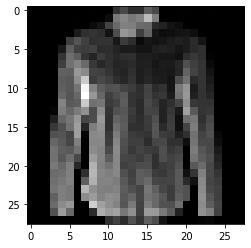

In [7]:
total_correct = 0
total_num = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    ps = Flatten()(torch.exp(model_d(images)))
    predictions = ps.topk(1, 1, True, True)[1].t()
    correct = predictions.eq(labels.view(1, -1))

    total_correct += correct.sum().cpu().numpy()
    total_num += images.shape[0]

print('Accuracy:', total_correct / float(total_num))

print('Correct Label:', labels[0].item())
print('Predicted Label:', predictions[0, 0].item())
index = 0
imshow(images[index, :].cpu())